## 每次奖励0,回合奖励为10000/最大完工时间，epsilon采用固定(0.05)的策略，使用一组算例进行训练，降低学习率为1e-4，增大了target_update，buffer_size，batch_size，minimal_size


In [1]:
import random
import time
import os
import numpy as np
import pandas as pd
import torch
from code_030_network import ACTSchedulingNetworkSolver
from code_040_rl import DQN, ReplayBuffer, add_data, add_log
from code_011_instances import training_instance_settings, test_instance_settings
from matplotlib import pyplot as plt

folder = '01_Data/06-27 20-23/'

### 模型是否收敛
对一段时间的内容取平均，看一下结果。

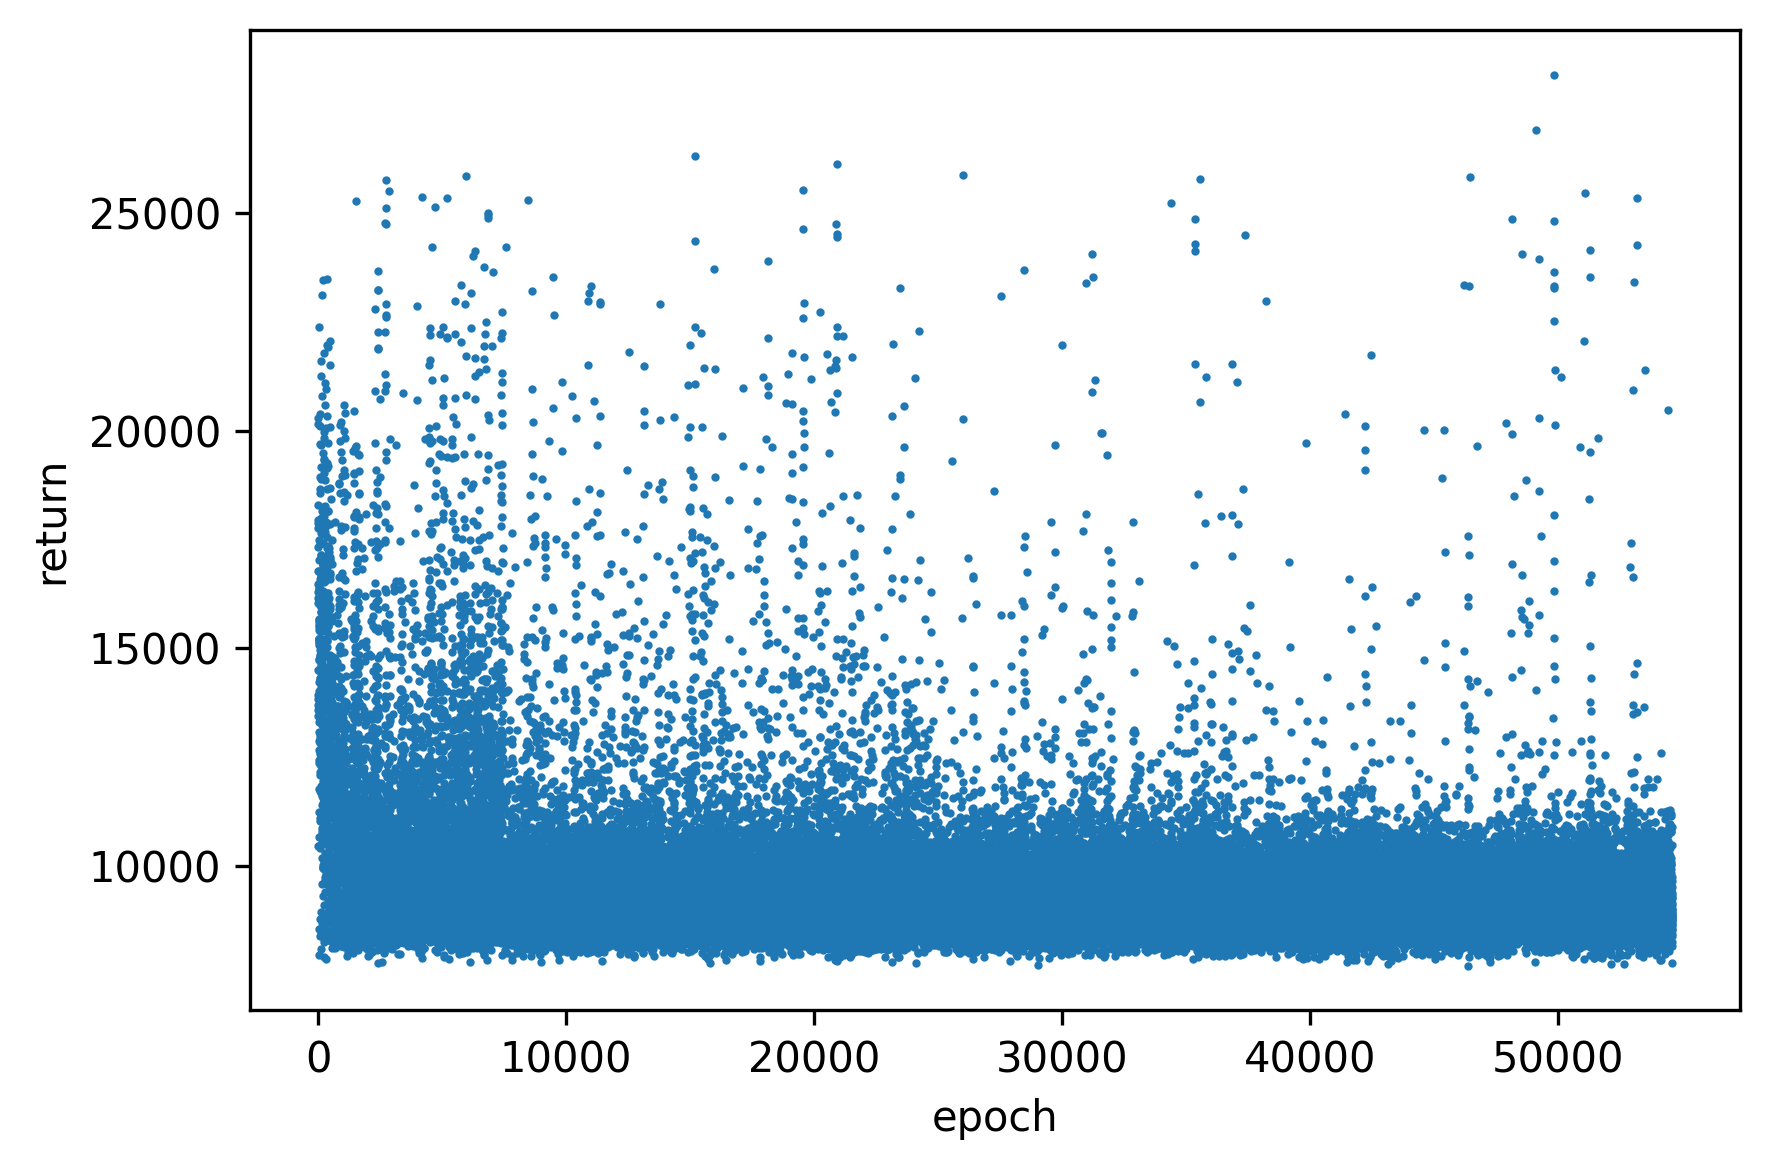

In [2]:
detail_result_path = folder + 'data.csv'
detail_result = pd.read_csv(detail_result_path)
plt.figure(figsize=(6,4), dpi=300)
plt.scatter(detail_result.index, detail_result['makespan'], s=1)
plt.xlabel('epoch')
plt.ylabel('return')
plt.tight_layout()
plt.show()

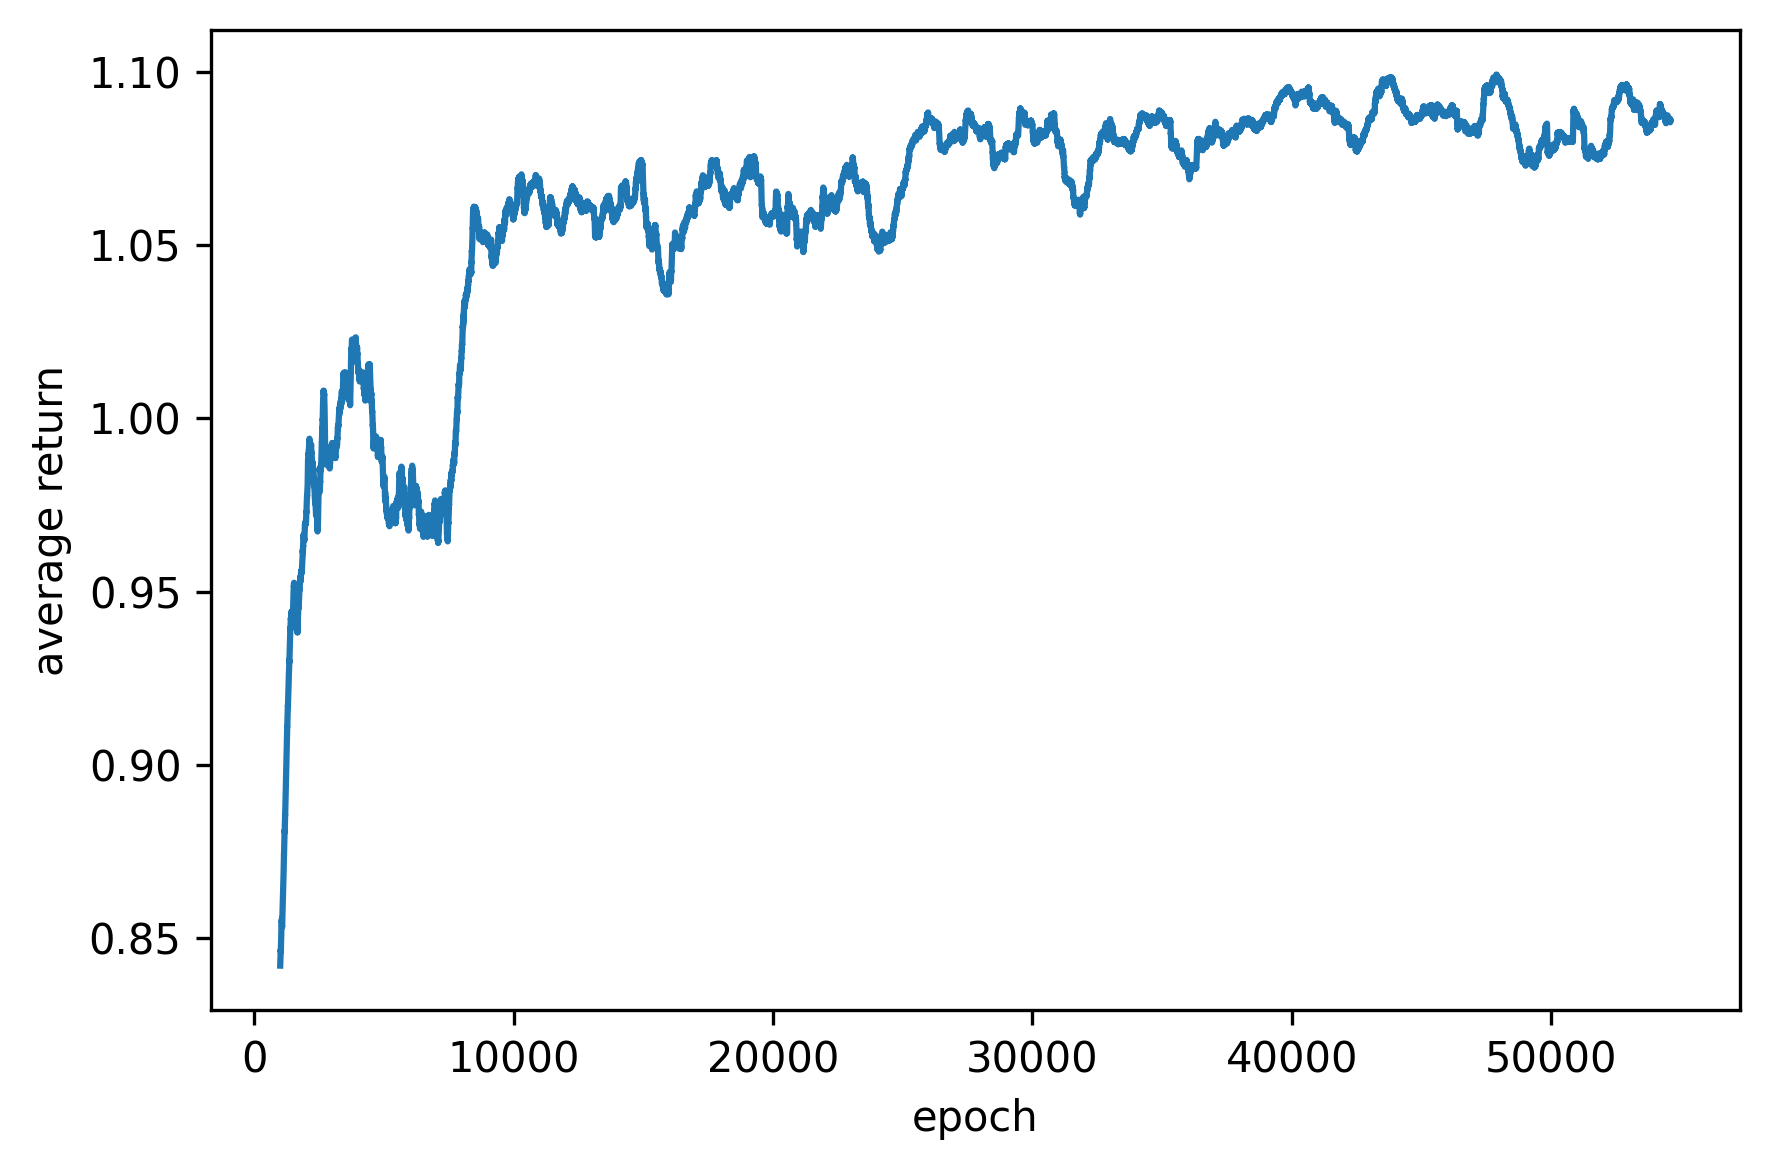

In [3]:
detail_result_rolling = detail_result[['return']].rolling(window=1000).mean()
plt.figure(figsize=(6,4), dpi=300)
plt.plot(detail_result_rolling['return'])
plt.xlabel('epoch')
plt.ylabel('average return')
plt.tight_layout()
plt.show()

超过大概7000个回合后，模型效果会下降。因此就本论文而言，先分析到1000回合。后面考虑看一下是不是周期设置的有问题。

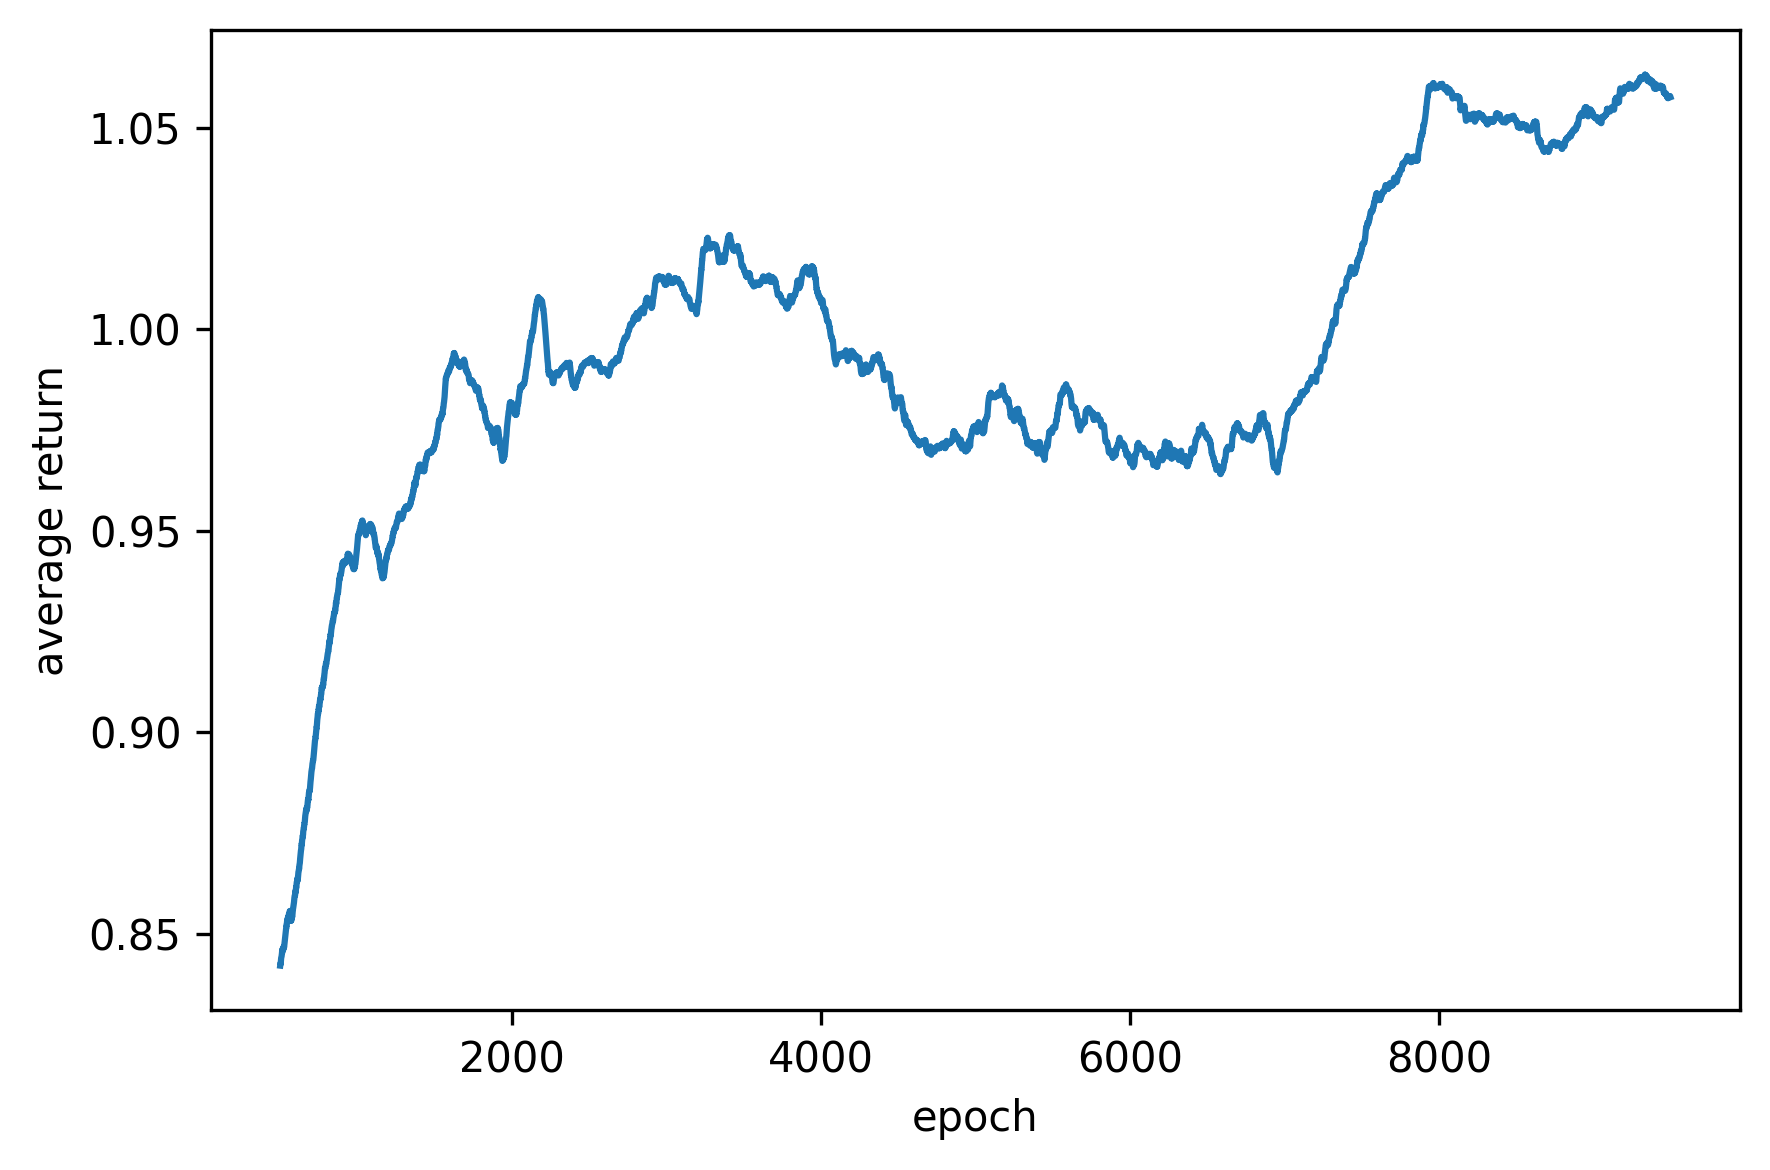

In [4]:
cut = 10000
detail_result_rolling = detail_result[:cut][['return']].rolling(window=1000, center=True).mean()
detail_result_rolling.dropna(inplace=True)
plt.figure(figsize=(6,4), dpi=300)
plt.plot(detail_result_rolling['return'])
plt.xlabel('epoch')
plt.ylabel('average return')
plt.tight_layout()
plt.show()

### 计算保存模型的结果
在训练的算例上，取epsilon为0，计算模型的makespan

In [5]:
lr = 0
hidden_dim = 128
gamma = 0.98
epsilon = 0
target_update = 10
buffer_size = 5000
minimal_size = 500
batch_size = 64
device = torch.device("cpu")
actions = ['min-degree', 'max-degree', 'min-processing_time', 'max-processing_time',
           'min-collective_influence', 'max-mapping_entropy']
attrs = list(set([action.split('-')[1] for action in actions]))
attrs.sort()
state_dim = len(attrs) * len(attrs)
action_dim = len(actions)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

training_result_file = folder+'rl_training_result.csv'
test_result_file = folder+'rl_test_result.csv'

calculated_models = []
if os.path.exists(training_result_file) and os.path.exists(test_result_file):
    training_result = pd.read_csv(training_result_file)
    test_result = pd.read_csv(test_result_file)
    calculated_models = list(training_result['epochs'])
print(calculated_models)
models = os.listdir(folder)
models = [model for model in models if model.startswith('model_weight')]
epochs = [int(x.split('_')[-1][:-4]) for x in models]
new_epochs = [epoch for epoch in epochs if epoch not in calculated_models]
new_training_result = {'epochs':new_epochs}
new_test_result = {'epochs':new_epochs}
for instance_setting in training_instance_settings+test_instance_settings:
    instance_name = '-'.join([str(x) for x in [instance_setting['n_agvs'], instance_setting['random_seed']]])
    print('***{}***'.format(instance_name))
    env = ACTSchedulingNetworkSolver(**instance_setting)
    instance_result = []
    for i, model in enumerate(models):
        if epochs[i] in calculated_models:
            continue
        print(folder+model)
        agent.q_net.load_state_dict(torch.load(folder+model, map_location=torch.device('cpu')))
        available_nodes = env.reset()
        state = env.cal_state(available_nodes, attrs)
        done = False
        while not done:
            action_idx = agent.take_action(state)
            available_nodes, reward, done = env.step(actions[action_idx])
            next_state = env.cal_state(available_nodes, attrs)
            state = next_state
        instance_result.append(env.clock)
    if instance_setting in training_instance_settings:
        new_training_result[instance_name] = instance_result.copy()
    else:
        new_test_result[instance_name] = instance_result.copy()
new_training_result = pd.DataFrame(new_training_result)
new_test_result = pd.DataFrame(new_test_result)

if len(calculated_models) > 0:
    training_result = pd.concat([training_result, new_training_result])
    test_result = pd.concat([test_result, new_test_result])
else:
    training_result = new_training_result
    test_result = new_test_result

training_result.to_csv(training_result_file, index=False)
test_result.to_csv(test_result_file, index=False)
    
training_result.set_index('epochs', inplace=True, drop=True)
training_result.sort_index(inplace=True)
training_result['average'] = training_result.mean(axis=1)
test_result.set_index('epochs', inplace=True, drop=True)
test_result.sort_index(inplace=True)
test_result['average'] = test_result.mean(axis=1)
xticks = [training_result.index[round(x/5*(len(training_result)-1))] for x in range(6)]
print(training_result.tail())
print(test_result.tail())

[0.0, 1000.0, 10000.0, 10500.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 500.0, 5000.0, 5500.0, 6000.0, 6500.0, 7000.0, 7500.0, 8000.0, 8500.0, 9000.0, 9500.0, 11000.0, 11500.0, 12000.0, 12500.0, 13000.0, 13500.0, 14000.0, 14500.0, 15000.0, 15500.0, 16000.0, 16500.0, 17000.0, 17500.0, 18000.0, 18500.0, 19000.0, 19500.0, 20000.0, 20500.0, 21000.0, 21500.0, 22000.0, 22500.0, 23000.0, 23500.0, 24000.0, 24500.0, 25000.0, 25500.0, 26000.0, 26500.0, 27000.0, 27500.0, 28000.0, 28500.0, 29000.0, 29500.0, 30000.0, 30500.0, 31000.0, 31500.0, 32000.0, 32500.0, 33000.0, 33500.0, 34000.0, 34500.0, 35000.0, 35500.0, 36000.0, 36500.0, 37000.0, 37500.0, 38000.0, 38500.0, 39000.0, 39500.0, 40000.0, 40500.0, 41000.0, 41500.0, 42000.0, 42500.0, 43000.0, 43500.0, 44000.0, 44500.0, 45000.0, 45500.0, 46000.0, 46500.0, 47000.0, 47500.0, 48000.0, 48500.0, 49000.0, 49500.0, 50000.0, 50500.0]
***9-1***
01_Data/06-27 20-23/model_weight_51000.pth


D:\OneDrive - sjtu.edu.cn\博士\030 科学研究\Github\ACT-RL-integrated-scheduling\code_040_rl.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  _state = torch.tensor([_state], dtype=torch.float).to(self.device)


01_Data/06-27 20-23/model_weight_51500.pth
01_Data/06-27 20-23/model_weight_52000.pth
01_Data/06-27 20-23/model_weight_52500.pth
01_Data/06-27 20-23/model_weight_53000.pth
01_Data/06-27 20-23/model_weight_53500.pth
01_Data/06-27 20-23/model_weight_54000.pth
01_Data/06-27 20-23/model_weight_54500.pth
***10-1***
01_Data/06-27 20-23/model_weight_51000.pth
01_Data/06-27 20-23/model_weight_51500.pth
01_Data/06-27 20-23/model_weight_52000.pth
01_Data/06-27 20-23/model_weight_52500.pth
01_Data/06-27 20-23/model_weight_53000.pth
01_Data/06-27 20-23/model_weight_53500.pth
01_Data/06-27 20-23/model_weight_54000.pth
01_Data/06-27 20-23/model_weight_54500.pth
***11-1***
01_Data/06-27 20-23/model_weight_51000.pth
01_Data/06-27 20-23/model_weight_51500.pth
01_Data/06-27 20-23/model_weight_52000.pth
01_Data/06-27 20-23/model_weight_52500.pth
01_Data/06-27 20-23/model_weight_53000.pth
01_Data/06-27 20-23/model_weight_53500.pth
01_Data/06-27 20-23/model_weight_54000.pth
01_Data/06-27 20-23/model_weight

### 保存的模型的趋势

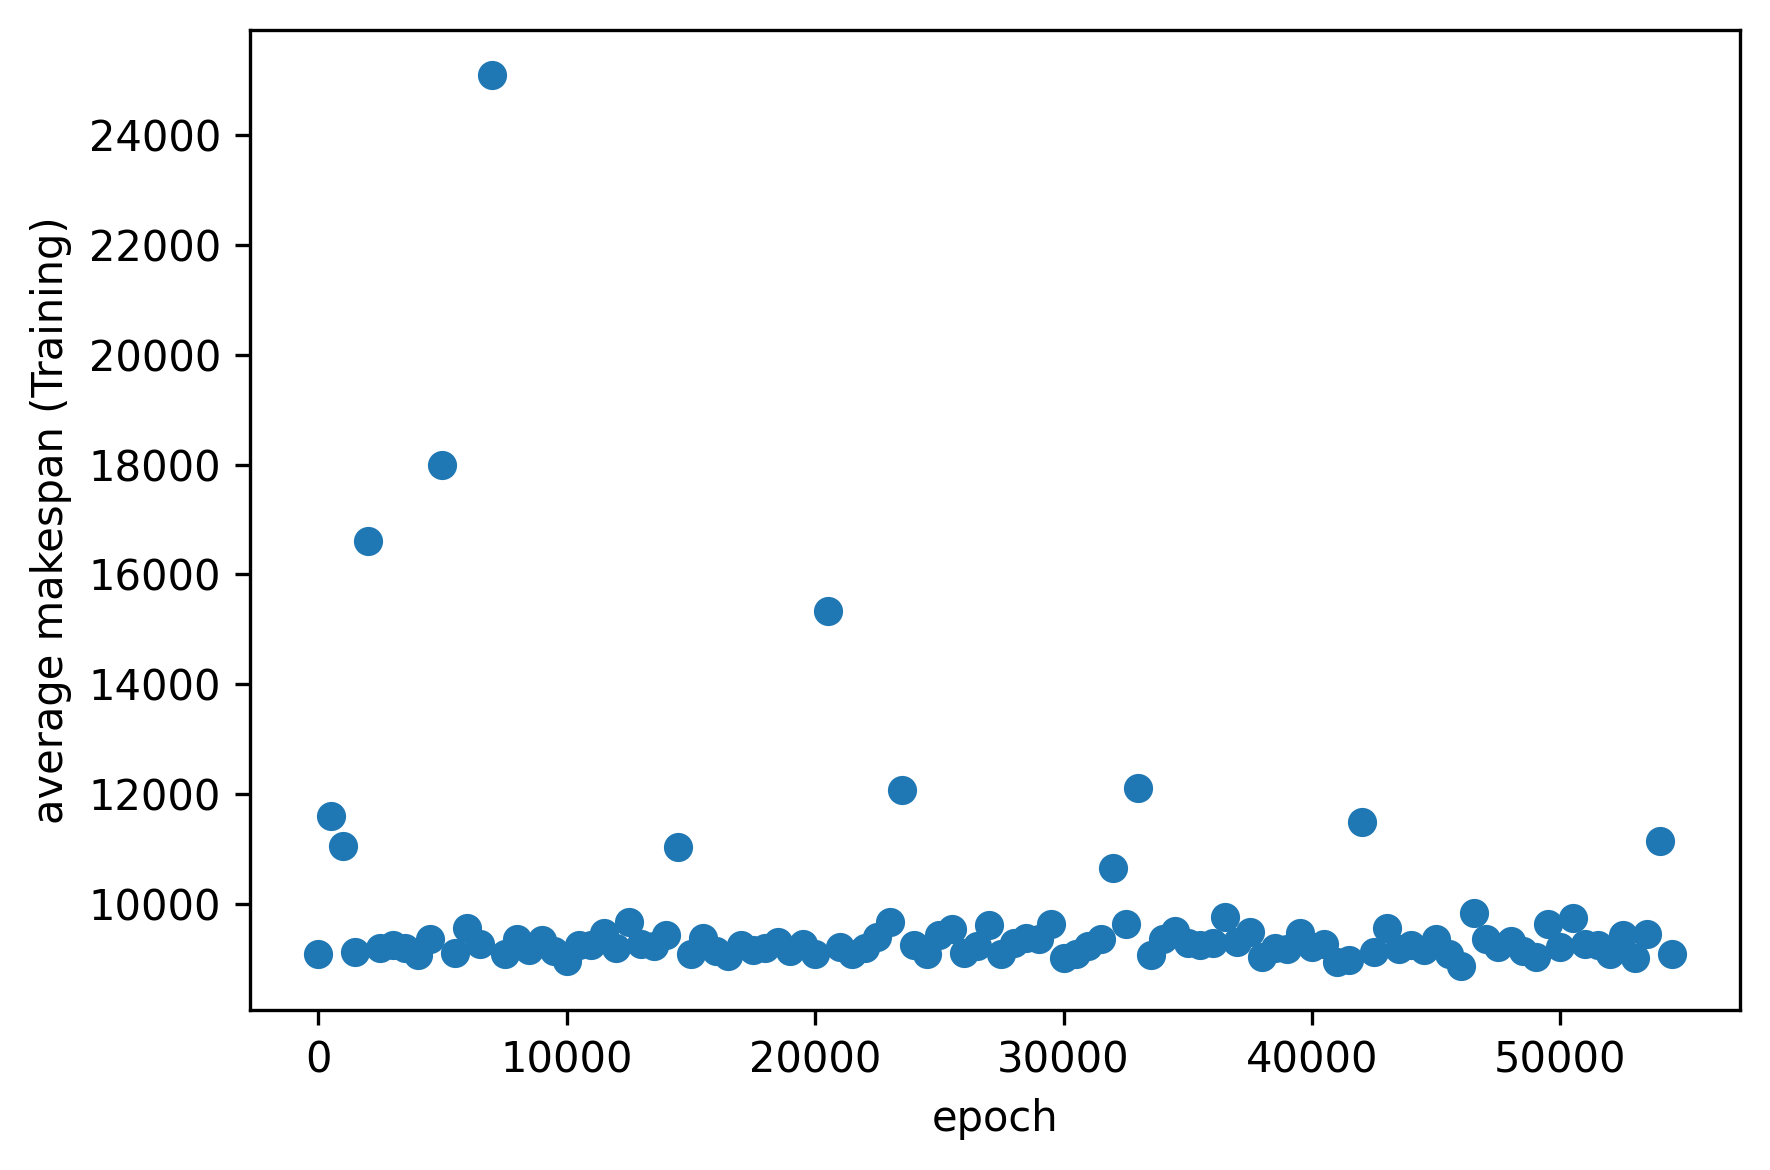

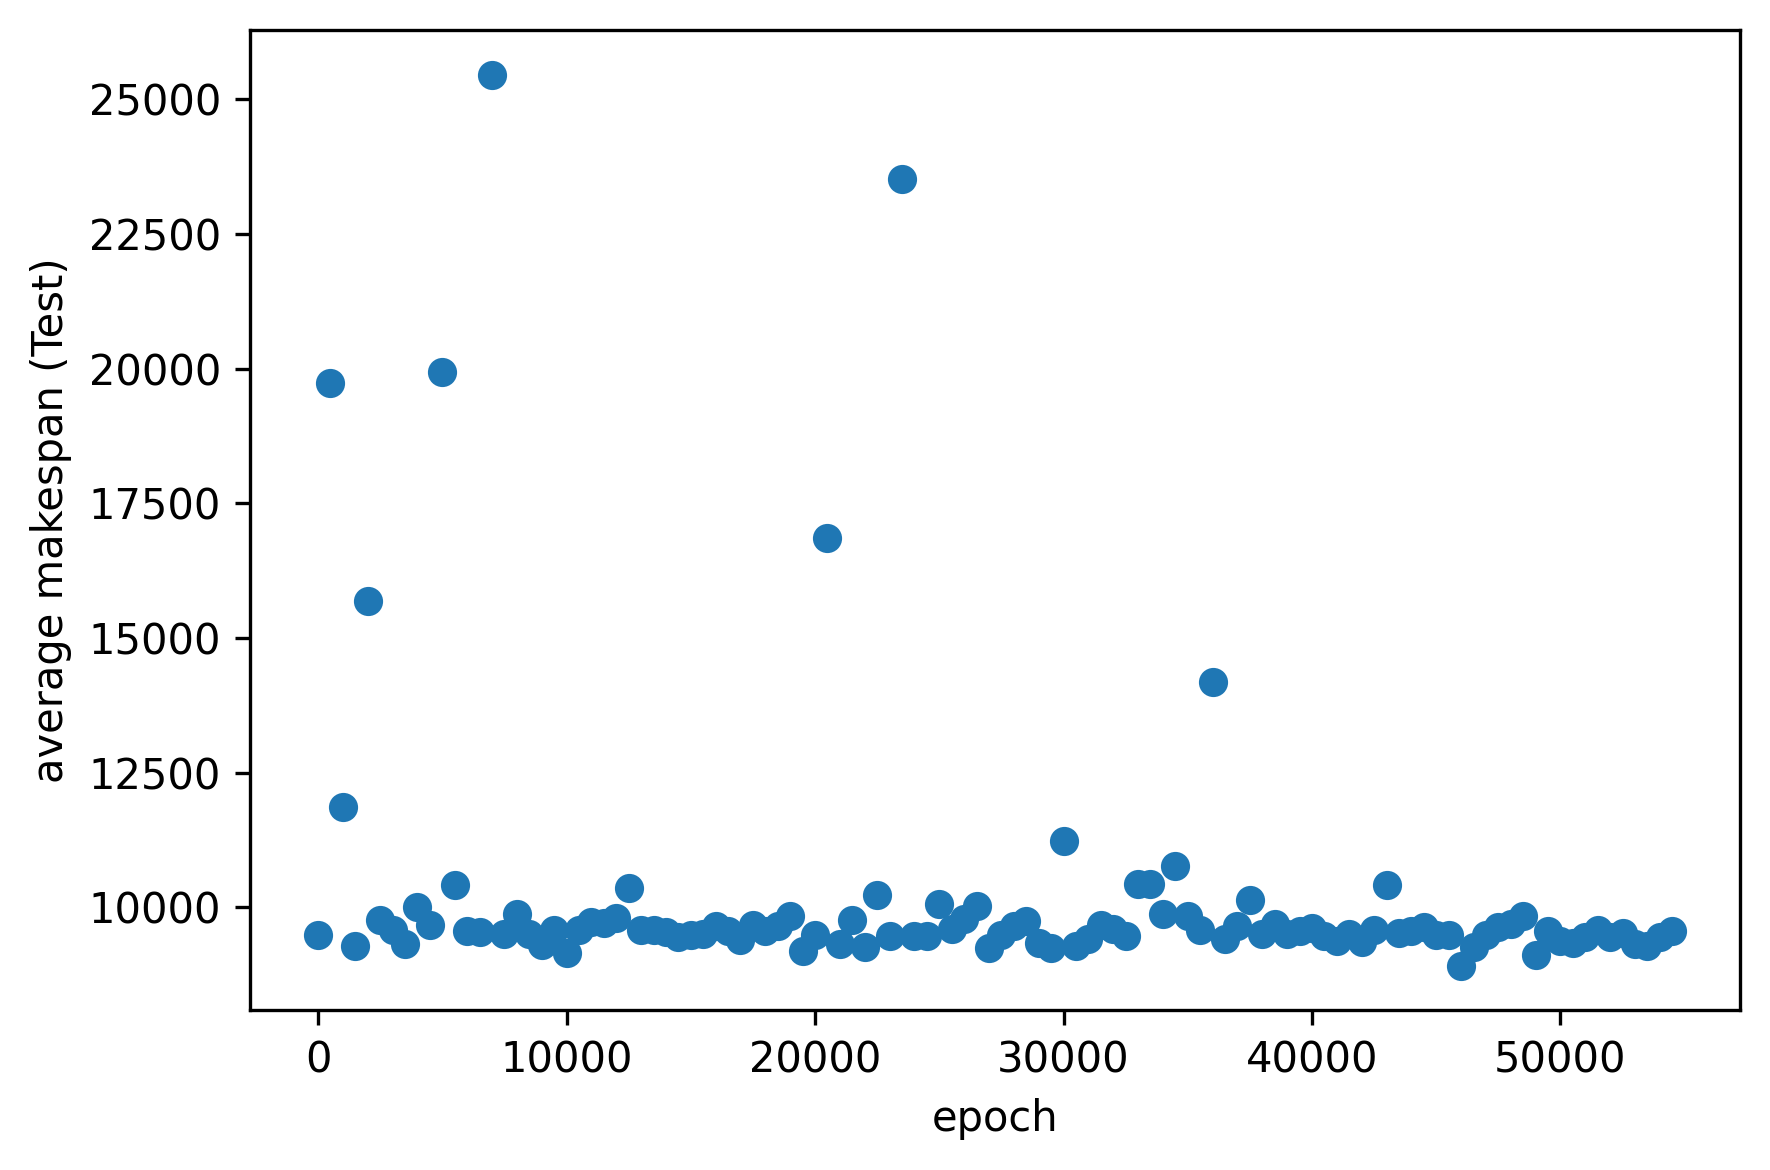

In [6]:
plt.figure(figsize=(6,4), dpi=300)
plt.scatter(training_result.index, training_result['average'])
plt.xlabel('epoch')
plt.ylabel('average makespan (Training)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4), dpi=300)
plt.scatter(test_result.index, test_result['average'])
plt.xlabel('epoch')
plt.ylabel('average makespan (Test)')
plt.tight_layout()
plt.show()

### 泛化性测试：训练集好，测试集也好

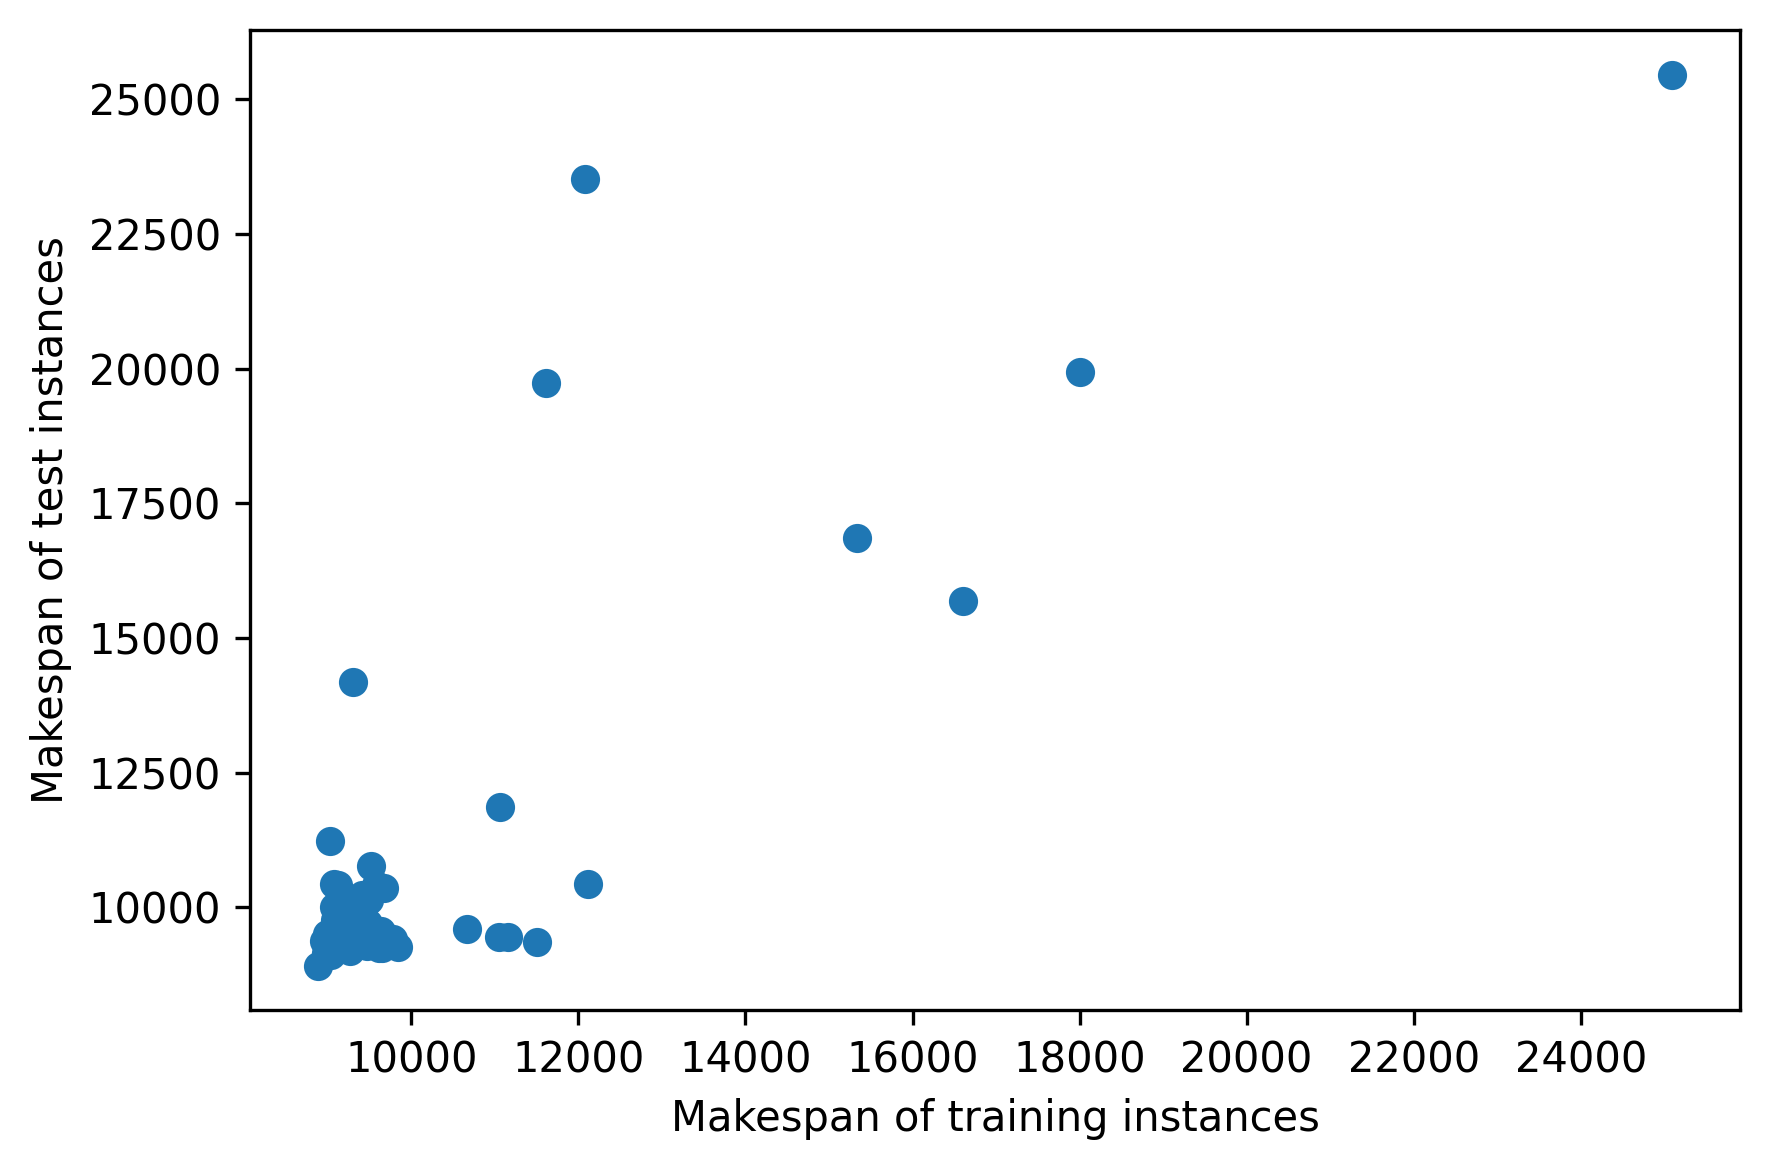

In [7]:
all_result = pd.concat([training_result['average'], test_result['average']], axis=1)
all_result.columns = ['training_instances', 'test_instances']
plt.figure(figsize=(6,4), dpi=300)
plt.scatter(all_result['training_instances'], all_result['test_instances'])
plt.xlabel('Makespan of training instances')
plt.ylabel('Makespan of test instances')
plt.tight_layout()
plt.show()

### 找一个最佳的模型

In [8]:
training_idx = training_result['average'].idxmin()
test_idx = test_result['average'].idxmin()
print(training_idx, test_idx)

46000.0 46000.0


### 计算规则结果

In [9]:
actions = ['min-degree', 'max-degree', 'min-processing_time', 'max-processing_time',
           'min-collective_influence', 'max-mapping_entropy']

rule_training_result_file = folder+'rule_training_result.csv'
if not os.path.exists(rule_training_result_file):
    rule_training_result = {}
    for instance_setting in training_instance_settings:
        instance_name = '-'.join([str(x) for x in [instance_setting['n_agvs'], instance_setting['random_seed']]])
        instance_result = []
        print('\n***{}***'.format(instance_name))
        env = ACTSchedulingNetworkSolver(**instance_setting)
        for action in actions:
            print(action, end='\t')
            available_nodes = env.reset()
            done = False
            reward = 0
            while not done:
                available_nodes, reward, done = env.step(action)
            instance_result.append(env.clock)
        rule_training_result[instance_name]=instance_result
    rule_training_result = pd.DataFrame(rule_training_result)
    rule_training_result.index = actions
    rule_training_result.to_csv(rule_training_result_file)
else:
    rule_training_result = pd.read_csv(rule_training_result_file, index_col=0)

rule_test_result_file = folder + 'rule_test_result.csv'
if not os.path.exists(rule_test_result_file):
    rule_test_result = {}
    for instance_setting in test_instance_settings:
        instance_name = '-'.join([str(x) for x in [instance_setting['n_agvs'], instance_setting['random_seed']]])
        instance_result = []
        print('\n***{}***'.format(instance_name))
        env = ACTSchedulingNetworkSolver(**instance_setting)
        for action in actions:
            print(action, end='\t')
            available_nodes = env.reset()
            done = False
            reward = 0
            while not done:
                available_nodes, reward, done = env.step(action)
            instance_result.append(env.clock)
        rule_test_result[instance_name]=instance_result
    rule_test_result = pd.DataFrame(rule_test_result)
    rule_test_result.index = actions
    rule_test_result.to_csv(rule_test_result_file)
else:
    rule_test_result = pd.read_csv(rule_test_result_file, index_col=0)
print(rule_training_result)
print(rule_test_result)

                               9-1      10-1      11-1       9-2      10-2  \
min-degree                 9178.72   9131.54   8657.95   9866.90   8749.40   
max-degree                16023.46  15490.28  15565.85  16405.78  15302.09   
min-processing_time       26546.82  26501.00  26362.02  27599.07  26621.23   
max-processing_time        9156.17   9026.26   9751.24   9692.41   9990.98   
min-collective_influence   9178.72   9131.54   8657.95  10851.69   8749.40   
max-mapping_entropy        9399.28   8973.86   8964.17  10372.35   8979.70   

                              11-2  
min-degree                 8979.18  
max-degree                15015.66  
min-processing_time       26507.22  
max-processing_time        9814.43  
min-collective_influence   8979.18  
max-mapping_entropy        9151.28  
                              8-10      8-20      9-10      9-20     10-10  \
min-degree                10374.13  10597.54   9851.06   9969.82   9016.50   
max-degree                15691.33  15

### 使用训练集上表现最好的模型
#### 训练集结果简单分析

In [10]:
all_training_result = rule_training_result.T.join(training_result.T[training_idx])
print(all_training_result.mean(axis=0))
all_training_result

min-degree                   9093.948333
max-degree                  15633.853333
min-processing_time         26689.560000
max-processing_time          9571.915000
min-collective_influence     9258.080000
max-mapping_entropy          9306.773333
46000.0                      8882.558333
dtype: float64


,min-degree,max-degree,min-processing_time,max-processing_time,min-collective_influence,max-mapping_entropy,46000.0
9-1,9178.72,16023.46,26546.82,9156.17,9178.72,9399.28,9307.62
10-1,9131.54,15490.28,26501.00,9026.26,9131.54,8973.86,8877.80
11-1,8657.95,15565.85,26362.02,9751.24,8657.95,8964.17,8963.78
9-2,9866.90,16405.78,27599.07,9692.41,10851.69,10372.35,8913.66
10-2,8749.40,15302.09,26621.23,9990.98,8749.40,8979.70,8167.88
11-2,8979.18,15015.66,26507.22,9814.43,8979.18,9151.28,9064.61


#### 测试集结果简单分析

In [11]:
all_test_result = rule_test_result.T.join(test_result.T[training_idx])
print(all_test_result.mean(axis=0))
all_test_result

min-degree                   9490.352
max-degree                  16977.015
min-processing_time         26391.024
max-processing_time         10426.208
min-collective_influence     9573.682
max-mapping_entropy          9650.997
46000.0                      8920.714
dtype: float64


,min-degree,max-degree,min-processing_time,max-processing_time,min-collective_influence,max-mapping_entropy,46000.0
8-10,10374.13,15691.33,26812.12,10200.26,11249.57,10314.45,9606.03
8-20,10597.54,15884.72,27298.61,10707.01,10475.76,10524.17,9581.82
9-10,9851.06,15355.73,26555.74,17894.11,10143.26,10685.05,9148.38
9-20,9969.82,15204.73,27778.69,11631.03,9488.28,9717.75,9015.54
10-10,9016.50,24304.10,25489.57,9383.23,8922.58,8732.75,8902.89
10-20,9145.59,14905.16,26574.27,9729.94,9244.58,9862.69,8586.80
11-10,9164.98,24312.67,25677.12,8375.04,9164.98,9058.40,8832.40
11-20,9174.97,14939.74,26524.39,8900.79,9064.89,9174.97,8567.97
12-10,8643.00,14523.69,25600.54,8617.36,8643.00,8594.41,8217.34
12-20,8965.93,14648.28,25599.19,8823.31,9339.92,9845.33,8747.97


### 使用测试集上表现最好的模型
#### 训练集结果简单分析

In [12]:
all_training_result = rule_training_result.T.join(training_result.T[test_idx])
print(all_training_result.mean(axis=0))
all_training_result

min-degree                   9093.948333
max-degree                  15633.853333
min-processing_time         26689.560000
max-processing_time          9571.915000
min-collective_influence     9258.080000
max-mapping_entropy          9306.773333
46000.0                      8882.558333
dtype: float64


,min-degree,max-degree,min-processing_time,max-processing_time,min-collective_influence,max-mapping_entropy,46000.0
9-1,9178.72,16023.46,26546.82,9156.17,9178.72,9399.28,9307.62
10-1,9131.54,15490.28,26501.00,9026.26,9131.54,8973.86,8877.80
11-1,8657.95,15565.85,26362.02,9751.24,8657.95,8964.17,8963.78
9-2,9866.90,16405.78,27599.07,9692.41,10851.69,10372.35,8913.66
10-2,8749.40,15302.09,26621.23,9990.98,8749.40,8979.70,8167.88
11-2,8979.18,15015.66,26507.22,9814.43,8979.18,9151.28,9064.61


#### 测试集结果简单分析

In [13]:
all_test_result = rule_test_result.T.join(test_result.T[test_idx])
print(all_test_result.mean(axis=0))
all_test_result

min-degree                   9490.352
max-degree                  16977.015
min-processing_time         26391.024
max-processing_time         10426.208
min-collective_influence     9573.682
max-mapping_entropy          9650.997
46000.0                      8920.714
dtype: float64


,min-degree,max-degree,min-processing_time,max-processing_time,min-collective_influence,max-mapping_entropy,46000.0
8-10,10374.13,15691.33,26812.12,10200.26,11249.57,10314.45,9606.03
8-20,10597.54,15884.72,27298.61,10707.01,10475.76,10524.17,9581.82
9-10,9851.06,15355.73,26555.74,17894.11,10143.26,10685.05,9148.38
9-20,9969.82,15204.73,27778.69,11631.03,9488.28,9717.75,9015.54
10-10,9016.50,24304.10,25489.57,9383.23,8922.58,8732.75,8902.89
10-20,9145.59,14905.16,26574.27,9729.94,9244.58,9862.69,8586.80
11-10,9164.98,24312.67,25677.12,8375.04,9164.98,9058.40,8832.40
11-20,9174.97,14939.74,26524.39,8900.79,9064.89,9174.97,8567.97
12-10,8643.00,14523.69,25600.54,8617.36,8643.00,8594.41,8217.34
12-20,8965.93,14648.28,25599.19,8823.31,9339.92,9845.33,8747.97
